<a href="https://colab.research.google.com/github/artjow/-AI-/blob/main/%EC%9D%B4%EB%A1%A0/Vanilla_GAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
'''
generator에서 tanh를 activation으로 활용

tanh를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에 Normalize를 해줄 때 127.5로 나눈 뒤 1을 빼줍니다.
'''
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [ ]:
#min 값과 max 값이 -1 ~ 1사이의 범위를 가져야 한다.
x_train.min(), x_train.max()

(-1.0, 1.0)

In [ ]:
#x_train 값은 현재 28 * 28로 되어 있다. 이를 Flatten하게 펴준다.
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [ ]:
#필요한 모듈을 import 
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
'''
Hyperparameters

NOISE_DIM을 정의 한다.
NOISE_DIM은 자유롭게 설정할 수 있으며, generator의 input으로 들어간다.
,,,

SyntaxError: ignored

In [ ]:
# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 준다.
# Vanilla Gan과 DCGAN세팅(학습이 잘된다고 함)
adam = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Generator 정의

generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [ ]:
# Discriminator정의
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [ ]:
#반드시 dicriminator를 compile 해주어야 합니다.
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
#Gan
#generator와 discriminator를 연결한다.
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 한다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)


In [ ]:
#gan 모델을 정의
gan = Model(gan_input, output)

In [ ]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [ ]:
#Compile
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
#Batch
#MNIST 이미지 batch가 차례대로 생성된다.
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [ ]:
#시각화를 위한 유틸 함수 정의
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#학습
BATCH_SIZE = 128
EPOCHS= 50

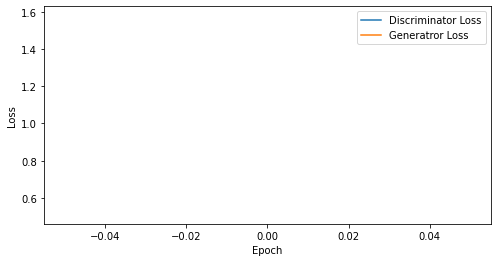

epoch: 1, Discriminator Loss: 0.5142294764518738, Generator Loss: 1.5757125616073608


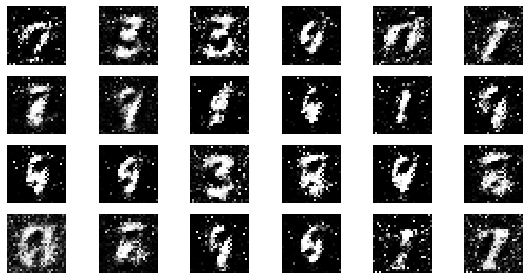

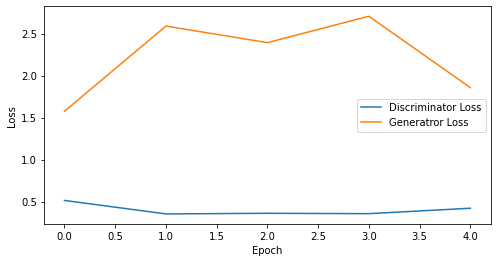

epoch: 5, Discriminator Loss: 0.40162994265556334, Generator Loss: 2.223816728591919


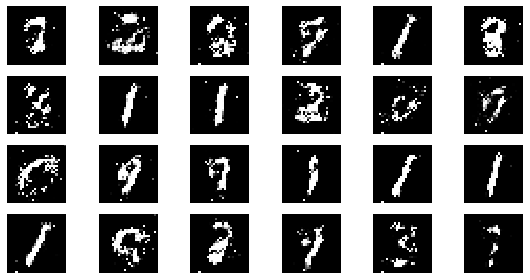

In [ ]:
# discriminator와 gan 모델의 loss 측정을 위한 list 
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지한다.
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)